**Indiquer dans la boîte ci-dessous vos noms et prénoms**

Double-cliquer ici et remplacer par les noms et prénoms de votre binôme

# 3I026 - Intelligence artificielle & Data science

# Projet

## Données

Vous devez travailler sur les données du projet Kaggle *European Soccer Database* accessible à l'adresse https://www.kaggle.com/hugomathien/soccer.

Les données en version SQLite sur la page http://www-connex.lip6.fr/~schwander/3I026/soccer.zip ou en version CSV http://www-connex.lip6.fr/~denoyer/wordpress/wp-content/uploads/2018/01/soccer.tar.gz. Pour facilter le travail dans les salles de la PPTI (et éviter de dépasser le quota de votre home), les données sont accessibles aussi dans `/Vrac/3I026/soccer/`.

Quel que soit le moyen pour récupérer le fichier de données, il est indispensable de lire en détail la page Kaggle pour comprendre à quoi ces données correspondent.

**Rappel:** il est attendu un notebook Python par problème, et le problème étudié doit être décrit précisément. Votre rapport devra impérativement suivre le format suivant.

## Partie 1 - Description du problème

La problèmatique de ce notebook se pose telle que si un joueur a un potentiel futur pour s'améliorer ou pas.<br>
Les attributs pertinent qu'on utilise sont le potentiel actuel du joueur, le plus ancien potentiel depuis sa carriere et son age actuel, avec une étude non supervisée sur ces données, notre modèle renverras donc +1 si le joueur compte améliorer son potentiel sur les prochaines saison ou -1 dans le cas inverse.

## Partie2 - Modéle

* imports

In [1]:
import random
import numpy as np
import pandas as pd
import math
import graphviz
import datetime
from mpl_toolkits import mplot3d
%matplotlib inline
import matplotlib.pyplot as plt

* LabeledSet

In [2]:
class LabeledSet:  
    
    def __init__(self, input_dimension):
        self.input_dimension = input_dimension
        self.nb_examples = 0
    
    def addExample(self,vector,label):
        if (self.nb_examples == 0):
            self.x = np.array([vector])
            self.y = np.array([label])
        else:
            self.x = np.vstack((self.x, vector))
            self.y = np.vstack((self.y, label))
        
        self.nb_examples = self.nb_examples + 1
    
    #Renvoie la dimension de l'espace d'entrée
    def getInputDimension(self):
        return self.input_dimension
    
    #Renvoie le nombre d'exemples dans le set
    def size(self):
        return self.nb_examples
    
    #Renvoie la valeur de x_i
    def getX(self, i):
        return self.x[i]
        
    
    #Renvouie la valeur de y_i
    def getY(self, i):
        return(self.y[i])

* Modéle

In [3]:
class Classifier:
    def __init__(self,input_dimension):
        """ Constructeur """
        raise NotImplementedError("Please Implement this method")
    
    
    # Permet de calculer la prediction sur x => renvoie un score
    def predict(self,x):
        raise NotImplementedError("Please Implement this method")

    
    # Permet d'entrainer le modele sur un ensemble de données étiquetés
    def train(self,labeledSet):
        raise NotImplementedError("Please Implement this method")
    
    # Permet de calculer le taux de bonne classification
    def accuracy(self,set):
        nb_ok=0
        for i in range(set.size()):
            score = self.predict(set.getX(i))
            if (score*set.getY(i)>0):
                nb_ok = nb_ok+1
        acc = nb_ok/(set.size() * 1.0)
        return acc


In [4]:
#KNN
class KNN(Classifier):
    def __init__(self, k, input_dimension):
        self.k = k
        self.datas = LabeledSet(input_dimension)
            
    def predict(self, x):
        dist=[]
        for i in range(self.datas.size()):
            dist.append(np.linalg.norm(x-self.datas.getX(i)))
        res=0
        ind=np.argsort(dist)
        for i in range(self.k):
            res+=self.datas.getY(ind[i])
        if ((res*1.0/self.k)>=0):
            return +1
        return -1

    def train(self, theSet):
        self.datas=theSet

## Partie 3 - Code

* Lecture des tables 

In [5]:
country = pd.read_csv("soccer/country.csv")
league = pd.read_csv("soccer/league.csv")
player = pd.read_csv("soccer/player.csv")
team = pd.read_csv("soccer/team.csv")
playerattributes = pd.read_csv("soccer/playerattributes.csv")
teamattributes = pd.read_csv("soccer/teamattributes.csv")
match = pd.read_csv("soccer/match.csv")

* Fonctions utiles

In [30]:
def labSetAgePotAm(date_actuel):
    finalSet = LabeledSet(3)
    
    for i in range(len(player)):
        idJ = player["player_api_id"][i]
        l = playerattributes[(playerattributes["player_api_id"]==idJ) & (playerattributes["date"]<date_actuel)]["potential"]
        old_pot = l.iloc[len(l)-1]
        new_pot = l.iloc[0]
        amelioration = new_pot-old_pot
        annee_naissance = int(player["birthday"][i][0:4])
        age = int(str(date_actuel)[0:4])-annee_naissance
        date_prediction = date_actuel + datetime.timedelta(1000)
        to_predict_pot = playerattributes[(playerattributes["player_api_id"]==idJ) & (playerattributes["date"]<date_prediction)]["potential"].iloc[0]
        y = 0
        if to_predict_pot-new_pot >= 0:
            y = +1
        else:
            y = -1
        finalSet.addExample((new_pot, old_pot, age), y)
    return finalSet

In [31]:
def plot3DSet(set):
    fig = plt.figure()
    ax = plt.axes(projection='3d')
    S_pos = set.x[np.where(set.y == 1),:][0]      # tous les exemples de label +1
    S_neg = set.x[np.where(set.y == -1),:][0]     # tous les exemples de label -1
    ax.set_xlabel('new potential')
    ax.set_ylabel('old potential')
    ax.set_zlabel('age ')
    ax.scatter3D(S_pos[:,0], S_pos[:,1], S_pos[:,2], c="green");
    ax.scatter3D(S_neg[:,0], S_neg[:,1], S_neg[:,2], c="blue");

* variables glabeles

In [32]:
playerattributes['date']  = pd.to_datetime(playerattributes['date'])


date_actuel = datetime.date(2014,1,1) 

k = 81
input_dimension = 3

## Partie 4 - Protocole expérimental

* preparation des données

In [33]:
theSet = labSetAgePotAm(date_actuel)
app = LabeledSet(input_dimension)
teste = LabeledSet(input_dimension)
for i in range(theSet.size()):
    if random.randint(0,4) == 0:
        app.addExample(theSet.getX(i), theSet.getY(i))
    else:
        teste.addExample(theSet.getX(i), theSet.getY(i))

In [34]:
knn = KNN(k, input_dimension)
knn.train(app)

## Partie 5 - Résultats

In [35]:
print("accuracy KNN : ",knn.accuracy(teste))

accuracy KNN :  0.7001359927470535


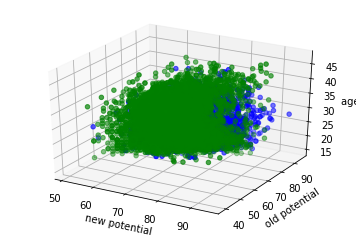

In [36]:
plot3DSet(teste)

## Partie 6 - Analyse

Meilleure score est de 70.5% de réussite.
